In [1]:
import math
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

RATES = [1,2,3,4,5]

def loadData(nbChunks = 0):  # <= 0 to load all chunks, positive integer to load specific number of chunks
    asinToIndex = {}
    scoreMatrix = []
    booksAsin = []
    index = 0
    chunks = pd.read_json(
        '../Dataset/Books.json', lines=True, chunksize=500000,
        typ="frame", orient="records", dtype={"asin": str, "overall": int, "unixReviewTime": int}
    )
    for chunk in chunks:
        for _, item in chunk.iterrows():
            asin = item["asin"]
            rate = item["overall"]
            if (asin not in asinToIndex):
                scoreMatrix.append([0,0,0,0,0])
                booksAsin.append(asin)
                asinToIndex[asin] = index
                index += 1
            row = asinToIndex[asin]
            scoreMatrix[row][rate-1] += 1
        nbChunks -= 1
        if (nbChunks == 0): break
    scoreMatrix = np.array(scoreMatrix)
    nbNonAppreciate = scoreMatrix[:,0]+scoreMatrix[:,1]
    nbNeutral = scoreMatrix[:,2]
    nbAppreciate = scoreMatrix[:,3]+scoreMatrix[:,4]
    realClass = np.argmax(np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate)), axis=1).astype(int)
    maxStarVotes = np.argmax(scoreMatrix, axis=1).astype(int)
    categoryMatrix = np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate, maxStarVotes, realClass))
    colNames = [f"{i} ⭐" for i in RATES]
    colNames.extend(["Depreciation", "Neutral", "Appreciations", "MaxStarVotes", "Class"])
    pdBooks = pd.DataFrame(data=np.concatenate((scoreMatrix, categoryMatrix), axis=1), index=booksAsin, columns=colNames)
    return pdBooks, scoreMatrix, categoryMatrix, booksAsin, asinToIndex

pdBooks, scoreMatrix, categoryMatrix, booksAsin, asinToIndex = loadData()
display(pdBooks)

def displayDifferentClassesCount(pdBooks):
    print("Different classes count : ")
    classesCount = np.array([
        [(pdBooks.Class.values == i).sum(), int(np.round(((pdBooks.Class.values == i).sum()/len(pdBooks.index))*100))] for i in range(0, 3)
    ])
    display(pd.DataFrame(
        data=np.array(classesCount),
        index=[ (i+1) * "⭐" for i in range(0,3) ],
        columns=["Count", "%"]
    ))

displayDifferentClassesCount(pdBooks)

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
000100039X,6,4,8,15,173,10,8,188,4,2
0001055178,0,4,2,10,2,4,2,12,3,2
0001473123,1,0,0,2,13,1,0,15,4,2
0001473727,0,0,0,0,7,0,0,7,4,2
0001473905,0,0,1,0,5,0,1,5,4,2
...,...,...,...,...,...,...,...,...,...,...
0060534095,0,0,0,1,4,0,0,5,4,2
0060534214,5,5,4,19,22,10,4,41,4,2
0060534249,2,2,5,12,17,4,5,29,4,2
0060534389,1,3,9,30,23,4,9,53,3,2


Different classes count : 


,Count,%
⭐,83,3
⭐⭐,57,2
⭐⭐⭐,2501,95


In [2]:
BOOKS_SAMPLING_NB = 10000
BAYES_QUARTILE_OPT = 0.25
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)
CRITERIAS = ["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "MaxStarVotes"]

class PlotData:
  def __init__(self, inputData, dataXY, dataLabels, title, axisLabels=[]):
    self.inputData = inputData
    self.dataXY = dataXY
    self.dataLabels = dataLabels
    self.title = title
    self.axisLabels = axisLabels

def getMedian(scoreMatrix, nbRating):
    def rowMedian(i):
        s = 0
        for k in sorted([0,1,2,3,4]):
            s += scoreMatrix[i,k]
            if s > nbRating[i] / 2:
                break
        return k + 1
    medianMat = np.array([ rowMedian(i) for i in range(0, nbRating.size) ])
    return medianMat

def getBookStats(pdBooks):
    scoreMatrix = pdBooks.to_numpy()
    starsMatrix = scoreMatrix[:,0:5]
    nbRating = np.sum(starsMatrix, axis=1)
    avgRatings = (np.average(starsMatrix, axis=1, weights=RATES) * np.sum(RATES)) / nbRating
    medianMat = getMedian(starsMatrix, nbRating)
    stdRatings = np.std(starsMatrix, axis=1)
    confidenceNumber = np.quantile(nbRating, BAYES_QUARTILE_OPT)
    arithAverage = np.mean(avgRatings)
    bayesAvgRatings = (nbRating * avgRatings + arithAverage * confidenceNumber) / (nbRating + confidenceNumber)
    calculatedPropsMat = np.column_stack((nbRating, avgRatings, bayesAvgRatings, medianMat, stdRatings))
    return pd.DataFrame(
        data=np.concatenate((calculatedPropsMat, scoreMatrix[:,5:]),axis=1),
        index=pdBooks.index, 
        columns=["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "MaxStarVotes", "Class"]
    )

pdBooksFeatures = getBookStats(pdBooks.sample(BOOKS_SAMPLING_NB))
display(pdBooksFeatures)
displayDifferentClassesCount(pdBooksFeatures)

,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
0060194197,30.0,3.500000,3.631165,4.0,2.280351,8.0,5.0,17.0,4.0,2.0
0007336977,5.0,4.400000,4.279424,4.0,1.264911,0.0,0.0,5.0,3.0,2.0
0028810252,12.0,4.250000,4.229110,4.0,2.727636,0.0,1.0,11.0,3.0,2.0
000741577X,5.0,4.000000,4.112758,4.0,1.095445,0.0,1.0,4.0,3.0,2.0
0060082194,37.0,4.108108,4.121661,4.0,6.086050,2.0,6.0,29.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...
0060531177,16.0,3.937500,4.015352,4.0,3.310589,0.0,4.0,12.0,3.0,2.0
0060502185,11.0,3.545455,3.797394,3.0,1.326650,2.0,4.0,5.0,2.0,2.0
0060507845,21.0,4.523810,4.441182,5.0,4.915282,0.0,2.0,19.0,4.0,2.0
006026683X,27.0,4.740741,4.628032,5.0,8.822698,1.0,1.0,25.0,4.0,2.0


Different classes count : 


,Count,%
⭐,35,4
⭐⭐,19,2
⭐⭐⭐,946,95


In [3]:
NB_CLUSTERS = 3
CLASSES = [f"C{i+1}" for i in range(0, NB_CLUSTERS)]

def kmeansClustering(booksData, distFunc, show=False):
    # Standardize data before doing kmeans :
    data = (booksData - booksData.mean()) / booksData.std()
    # As per : https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python
    if (distFunc == "cosine"): data = preprocessing.normalize(data)
    kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(data)
    # K means
    if (show):
        print(f"K-means ({distFunc}):")
        display(pd.DataFrame(
            data=np.array([ [f"C{i+1}" for i in kmeans.labels_] ]),
            index=["Class"],
            columns=booksData.index
        ))
        display(pd.DataFrame(
            data=np.array([[np.count_nonzero(kmeans.labels_ == i) for i in range(0, NB_CLUSTERS)]]),
            index=["Number of Classes"],
            columns=CLASSES
        ))
    return data, kmeans

kmeansEucliCoords, kmeansEucliOutput = kmeansClustering(pdBooksFeatures[CRITERIAS], "euclidean", True)
kmeansCosCoords, kmeansCosOutput = kmeansClustering(pdBooksFeatures[CRITERIAS], "cosine", True)

K-means (euclidean):


,0060194197,0007336977,0028810252,000741577X,0060082194,0060185546,0007284926,0060001054,0060390778,0007232616,...,0060004797,0060508876,0060514051,0060294515,0060096640,0060531177,0060502185,0060507845,006026683X,0060194995
Class,C1,C1,C1,C1,C1,C2,C2,C2,C2,C2,...,C2,C2,C1,C2,C2,C1,C1,C2,C2,C2


,C1,C2,C3
Number of Classes,385,612,3


K-means (cosine):


,0060194197,0007336977,0028810252,000741577X,0060082194,0060185546,0007284926,0060001054,0060390778,0007232616,...,0060004797,0060508876,0060514051,0060294515,0060096640,0060531177,0060502185,0060507845,006026683X,0060194995
Class,C3,C1,C1,C1,C3,C2,C2,C2,C2,C2,...,C2,C2,C1,C2,C2,C1,C1,C2,C2,C2


,C1,C2,C3
Number of Classes,270,556,174


Standardized/Normalized books features matrix : 


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
0060194197,-0.065275,-1.312545,-1.677119,-0.721327,-0.150703,0.093857,0.011921,-0.108303,0.507582,0.22886
0007336977,-0.190495,0.391324,0.269722,-0.721327,-0.174195,-0.129745,-0.190815,-0.186200,-0.686729,0.22886
0028810252,-0.155433,0.107346,0.118620,-0.721327,-0.140355,-0.129745,-0.150268,-0.147252,-0.686729,0.22886
000741577X,-0.190495,-0.365951,-0.230808,-0.721327,-0.178115,-0.129745,-0.150268,-0.192692,-0.686729,0.22886
0060082194,-0.030213,-0.161282,-0.204069,-0.721327,-0.062660,-0.073844,0.052468,-0.030406,0.507582,0.22886
...,...,...,...,...,...,...,...,...,...,...
0060531177,-0.135398,-0.484275,-0.523335,-0.721327,-0.126869,-0.129745,-0.028626,-0.140760,-0.686729,0.22886
0060502185,-0.160442,-1.226491,-1.177902,-2.163981,-0.172767,-0.073844,-0.028626,-0.186200,-1.881040,0.22886
0060507845,-0.110354,0.625719,0.755509,0.721327,-0.089745,-0.129745,-0.109720,-0.095320,0.507582,0.22886
006026683X,-0.080301,1.036411,1.316655,0.721327,0.000651,-0.101795,-0.150268,-0.056372,0.507582,0.22886


PC axis composition : 


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Nb rating,0.485830,0.061665,0.091654,-0.024978,-0.005032,0.004229,-0.013978,0.015238,0.376740,7.802167e-01
Average Rating,0.052512,-0.470487,0.108557,0.372892,-0.217733,-0.244075,0.694061,0.188942,0.025545,-0.000000e+00
Bayes Rating,0.047385,-0.458051,0.209219,0.416461,-0.253563,-0.180758,-0.660059,-0.193219,-0.027451,3.480289e-17
Median,0.064856,-0.462027,-0.024090,0.097381,0.343811,0.806893,0.010450,0.053547,-0.001938,-1.387779e-16
STD,0.416870,0.014239,0.529251,-0.230721,0.030302,0.013473,0.103642,-0.166526,-0.673131,-0.000000e+00
Depreciation,0.398611,0.112679,-0.516736,0.280735,-0.032434,0.038282,0.160536,-0.655944,-0.066969,-1.398183e-01
Neutral,0.435854,0.102918,-0.395436,0.189879,-0.048716,-0.033139,-0.203558,0.677740,-0.305758,-9.638055e-02
Appreciations,0.467283,0.037272,0.302104,-0.127971,0.008810,0.001896,-0.022811,0.063588,0.552761,-6.020162e-01
MaxStarVotes,0.094878,-0.425197,-0.224623,-0.298384,0.648680,-0.494703,-0.059091,-0.041116,-0.004201,3.816392e-17
Class,0.069029,-0.381952,-0.300411,-0.635529,-0.587248,0.095815,-0.018343,-0.028457,-0.003999,1.040834e-17


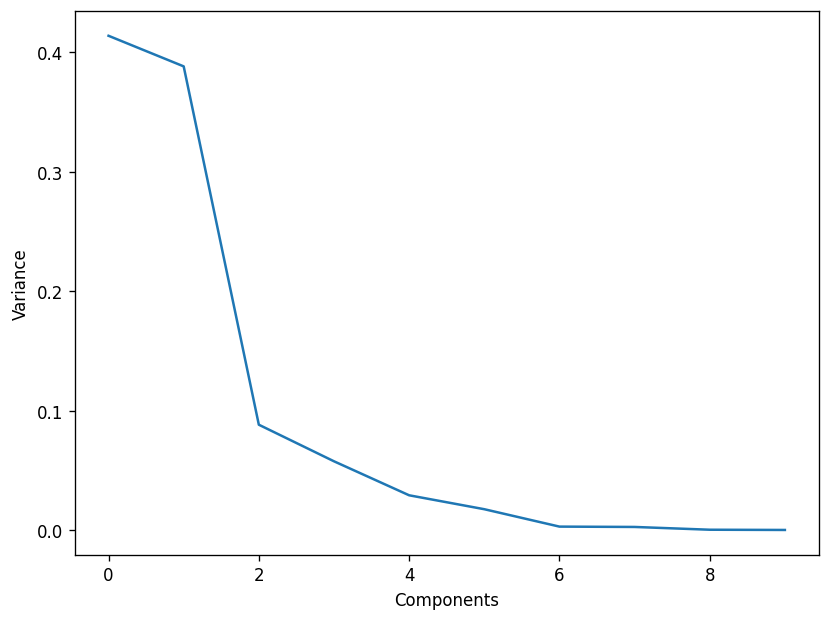

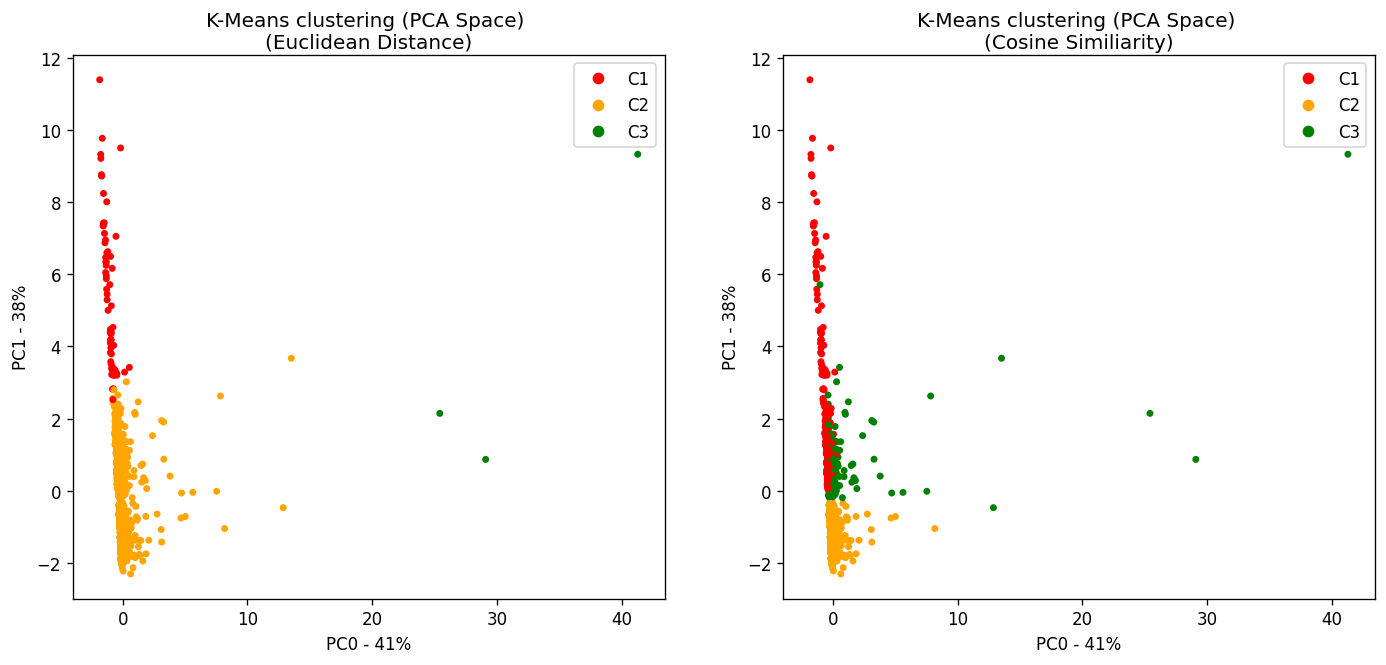

Standardized/Normalized books features matrix : 


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
0060194197,-0.028055,-0.564126,-0.720818,-0.310023,-0.064772,0.040339,0.005124,-0.046548,0.218156,0.098363
0007336977,-0.159595,0.327848,0.225971,-0.604321,-0.145939,-0.108699,-0.159863,-0.155997,-0.575335,0.191737
0028810252,-0.143402,0.099037,0.109438,-0.665493,-0.129491,-0.119702,-0.138636,-0.135854,-0.633573,0.211146
000741577X,-0.162393,-0.311966,-0.196759,-0.614918,-0.151840,-0.110605,-0.128100,-0.164266,-0.585424,0.195099
0060082194,-0.031638,-0.168888,-0.213693,-0.755345,-0.065615,-0.077327,0.054942,-0.031840,0.531520,0.239654
...,...,...,...,...,...,...,...,...,...,...
0060531177,-0.106229,-0.379945,-0.410590,-0.565928,-0.099537,-0.101793,-0.022459,-0.110436,-0.538784,0.179556
0060502185,-0.047810,-0.365478,-0.350999,-0.644837,-0.051482,-0.022005,-0.008530,-0.055485,-0.560525,0.068197
0060507845,-0.081115,0.459934,0.555336,0.530210,-0.065967,-0.095369,-0.080650,-0.070065,0.373097,0.168223
006026683X,-0.041856,0.540221,0.686295,0.375986,0.000339,-0.053060,-0.078326,-0.029383,0.264573,0.119292


PC axis composition : 


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Nb rating,0.012805,-0.009523,0.346093,0.336439,-0.136543,-0.006091,-0.088736,0.036905,0.360720,7.802167e-01
Average Rating,-0.492136,0.485579,0.135940,-0.119494,0.062433,0.592438,-0.291241,-0.222574,-0.003924,0.000000e+00
Bayes Rating,-0.490225,0.483904,0.107270,-0.028570,0.004194,-0.554411,0.344576,0.295078,0.000705,1.040834e-16
Median,-0.601612,-0.409262,-0.487607,0.462142,-0.124815,0.052821,0.015756,-0.023719,0.007299,-5.551115e-17
STD,-0.009095,0.018303,0.309909,0.338675,-0.128806,-0.272720,-0.340454,-0.236271,-0.725354,9.992007e-16
Depreciation,0.030977,-0.047556,0.159683,0.179794,-0.021763,0.304169,-0.184084,0.875954,-0.158838,-1.398183e-01
Neutral,0.041623,-0.040749,0.328428,0.260234,-0.110576,0.383989,0.774226,-0.138849,-0.182625,-9.638055e-02
Appreciations,0.002737,0.005226,0.358872,0.352608,-0.154204,-0.140013,-0.196199,-0.133383,0.533623,-6.020162e-01
MaxStarVotes,-0.383802,-0.593353,0.503677,-0.413235,0.267374,-0.066737,-0.014816,0.000431,-0.003480,6.938894e-18
Class,-0.072768,-0.078184,0.024220,-0.385091,-0.915042,0.020432,-0.019723,0.035703,-0.018080,-9.020562e-17


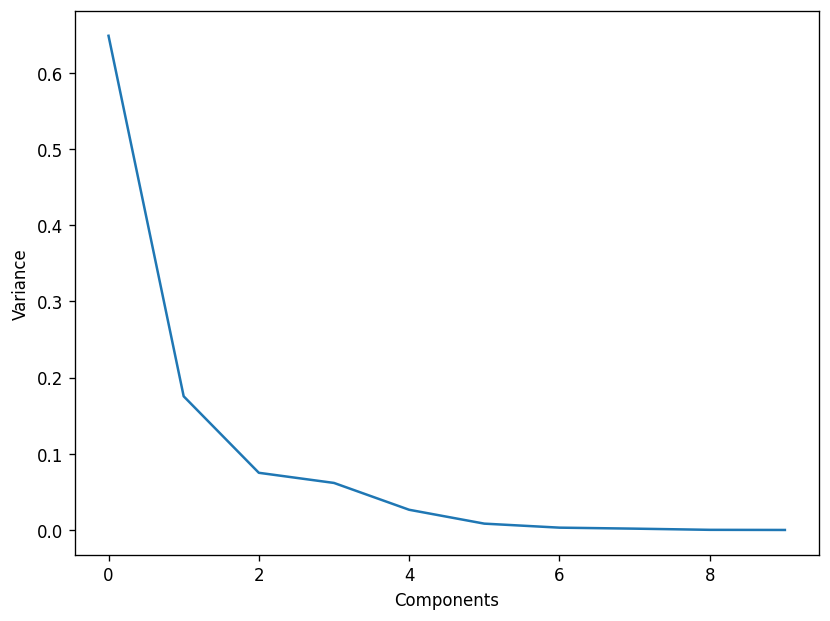

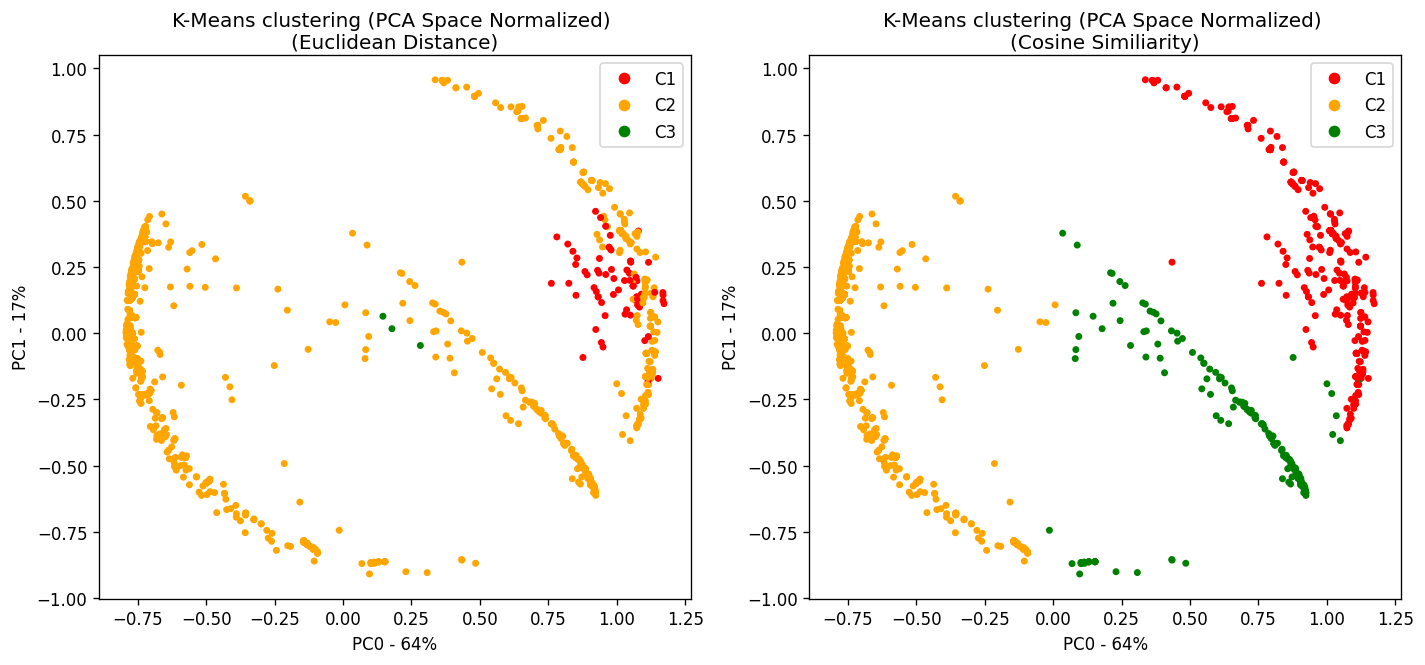

In [4]:
def scatterPlotHelper(plotData):
    fig, ax = plt.subplots(1, len(plotData), figsize=(14,6), dpi=120)
    for i in range(len(plotData)):
        if (plotData[i].axisLabels != []): ax[i].set(xlabel=plotData[i].axisLabels[0], ylabel=plotData[i].axisLabels[1])
        scatter = ax[i].scatter(x=plotData[i].dataXY[0], y=plotData[i].dataXY[1], c=plotData[i].dataLabels, cmap=colors, s=10)
        ax[i].legend(handles=scatter.legend_elements(num=3)[0], labels=CLASSES)
        ax[i].set_title(plotData[i].title, loc='center', wrap=True)
    plt.show()


def calculatePCA(booksData, normalize=False):
    # Data Standardization
    pdBooksFeaturesStandardized = (booksData - booksData.mean()) / booksData.std()
    if (normalize):
        pdBooksFeaturesNormalized = pd.DataFrame(
            data=preprocessing.normalize(pdBooksFeaturesStandardized), 
            columns=booksData.columns, 
            index=booksData.index
        )
    else:
        pdBooksFeaturesNormalized = pdBooksFeaturesStandardized
    # PCA Calculations
    pca = PCA(n_components=booksData.shape[1])
    pca.fit(pdBooksFeaturesNormalized)
    # PCA Results
    booksFeaturesPCA = pd.DataFrame(
        data=pca.components_.T,
        columns=[f"PC{i}" for i in range(len(booksData.columns))],
        index=booksData.columns
    )
    return pdBooksFeaturesNormalized, booksFeaturesPCA, pca

def displayPCAResults(pdBooksFeaturesStandNorm, booksFeaturesPCA, pca):
    # Display standardized data 
    print("Standardized/Normalized books features matrix : ")
    display(pdBooksFeaturesStandNorm)
    # Plot all PCA axis and their contributions
    print("PC axis composition : ")
    display(booksFeaturesPCA)
    # Plot PCA (2 major axis)
    plt.figure(figsize=(8, 6), dpi=120)
    plt.plot(pca.explained_variance_ratio_)
    plt.ylabel("Variance")
    plt.xlabel("Components")
    plt.show()

def displayKmeansClustering(booksData, normalizePca=False, displayPcaResults=False):
    kmeansEucliCoords, kmeansEucliOutput = kmeansClustering(booksData, "euclidean")
    kmeansCosCoords, kmeansCosOutput = kmeansClustering(booksData, "cosine")
    pdBooksFeaturesStandNorm, booksFeaturesPCA, pca = calculatePCA(booksData, normalizePca)
    if (displayPcaResults): displayPCAResults(pdBooksFeaturesStandNorm, booksFeaturesPCA, pca)
    pcaSpace = pca.transform(pdBooksFeaturesStandNorm)
    pcaSpaceXY = (pcaSpace[:,0], pcaSpace[:,1])
    pcaAxisLabels = [f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC1 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
    kmeansEucli = PlotData(
        inputData=kmeansEucliCoords,
        dataXY=pcaSpaceXY,
        dataLabels=kmeansEucliOutput.labels_, 
        title=f"K-Means clustering (PCA Space{' Normalized' if normalizePca else ''}) \n(Euclidean Distance)",
        axisLabels=pcaAxisLabels
    )
    kmeansCos = PlotData(
        inputData=kmeansCosCoords,
        dataXY=pcaSpaceXY,
        dataLabels=kmeansCosOutput.labels_, 
        title=f"K-Means clustering (PCA Space{' Normalized' if normalizePca else ''}) \n(Cosine Similiarity)",
        axisLabels=pcaAxisLabels
    )
    scatterPlotHelper([kmeansEucli, kmeansCos])
    return kmeansEucli, kmeansCos

kmeansEucli, kmeansCos = displayKmeansClustering(pdBooksFeatures, normalizePca=False, displayPcaResults=True)
kmeansEucliNorm, kmeansCosNorm = displayKmeansClustering(pdBooksFeatures, normalizePca=True, displayPcaResults=True)

**Q3 : Interprétation des résultats visuelles**
TODO

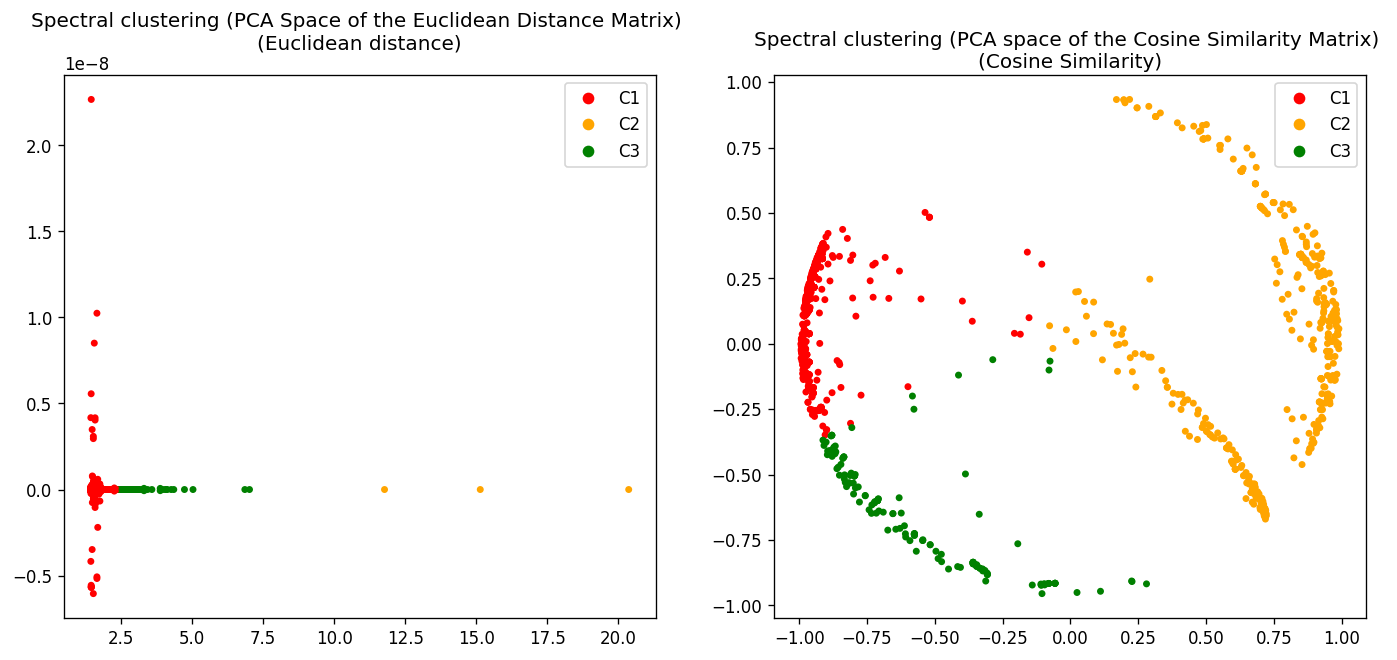

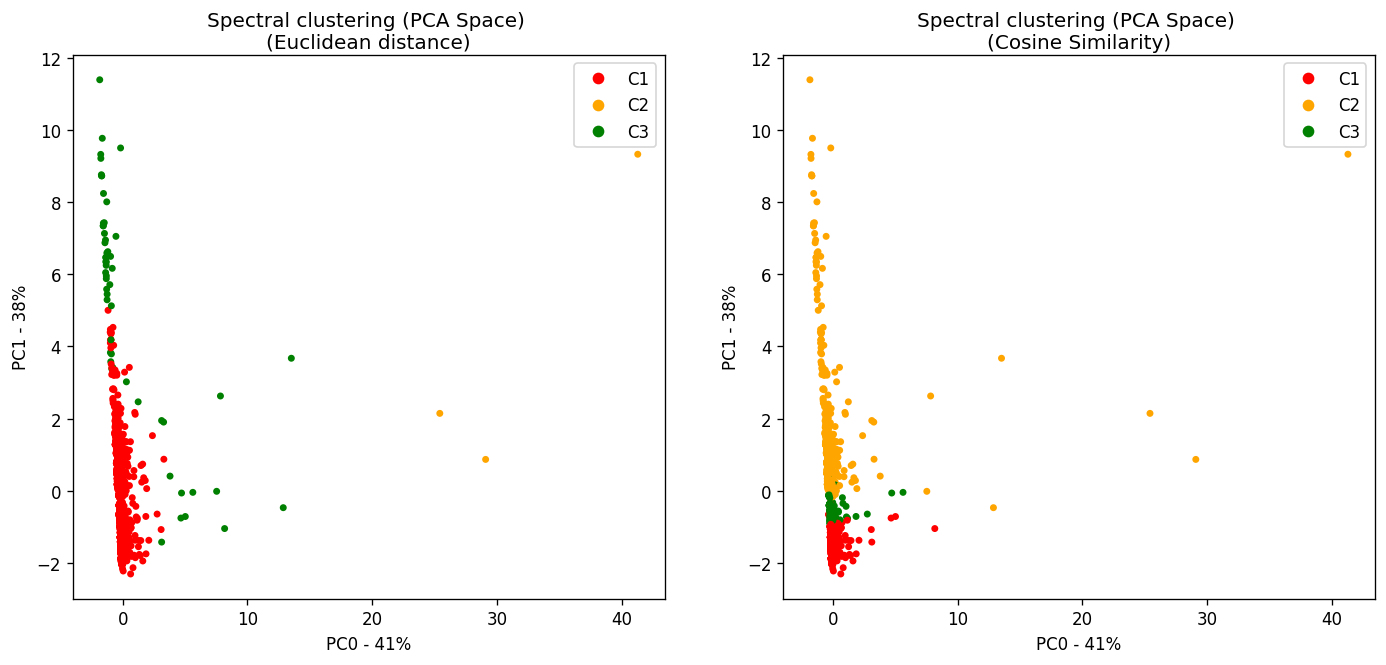

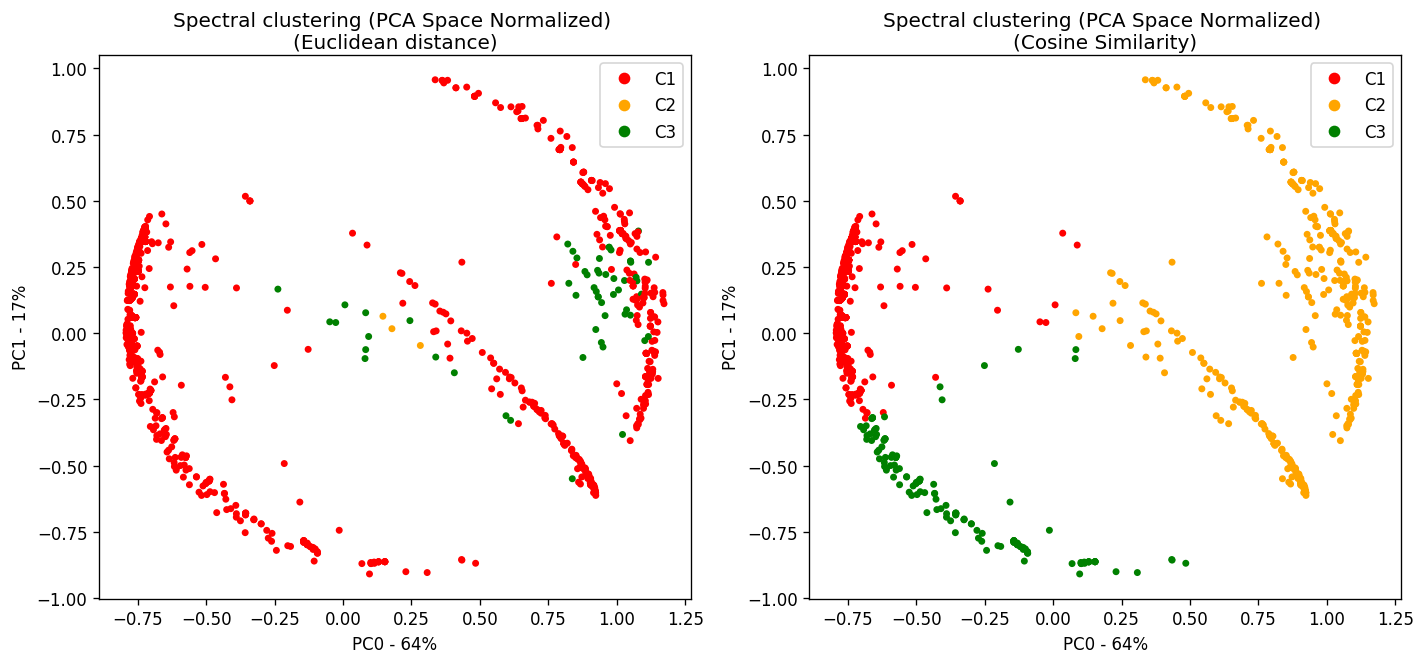

In [5]:
# Q4
def spectralClustering(booksData, distFunc):
    eucli = lambda x, y: np.linalg.norm(x-y)
    cosSim = lambda x, y: (x @ y.T) / (np.linalg.norm(x) * np.linalg.norm(y))
    funcMap = {"euclidean": eucli, "cosine": cosSim}
    # Standardize data before doing kmeans :
    data = (booksData - booksData.mean()) / booksData.std()
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    M = sp.spatial.distance.squareform(sp.spatial.distance.pdist(np.asarray(data), distFunc))
    if (distFunc == "cosine"): M = 1 - M # SciPy uses distance cos which is equal to 1 - sim cos
    eigenValues, eigenVectors = np.linalg.eig(M)
    idx =  eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx].real
    eigenVectors = eigenVectors[:,idx].real
    positiveCount = eigenValues[eigenValues > 0].size
    P = np.stack(eigenVectors[:,0:positiveCount])
    D = np.diag(eigenValues[0:positiveCount])
    spectralDataMat = P @ np.sqrt(D)
    kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(spectralDataMat[:,0:2])
    return spectralDataMat[:,0:2], kmeans

def displaySpectralClustering(booksData, kmeansEucli, kmeansCos, kmeansEucliNorm, kmeansCosNorm):
    eucliCoords, spectralEucliOutput = spectralClustering(booksData, "euclidean")
    cosCoords, spectralCosOutput =  spectralClustering(booksData, "cosine")
    spectralEucli = PlotData(
        inputData=eucliCoords,
        dataXY=(eucliCoords[:,0],eucliCoords[:,1]), 
        dataLabels=spectralEucliOutput.labels_, 
        title="Spectral clustering (PCA Space of the Euclidean Distance Matrix) \n(Euclidean distance)"
    )
    spectralCos = PlotData(
        inputData=cosCoords,
        dataXY=(cosCoords[:,0],cosCoords[:,1]), 
        dataLabels=spectralCosOutput.labels_, 
        title="Spectral clustering (PCA space of the Cosine Similarity Matrix) \n(Cosine Similarity)"
    )
    scatterPlotHelper([spectralEucli, spectralCos])
    spectralEucliPCASpace = PlotData(
        inputData=eucliCoords,
        dataXY=kmeansEucli.dataXY, 
        dataLabels=spectralEucliOutput.labels_, 
        title="Spectral clustering (PCA Space) \n(Euclidean distance)",
        axisLabels=kmeansEucli.axisLabels
    )
    spectralCosPCASpace = PlotData(
        inputData=cosCoords,
        dataXY=kmeansCos.dataXY, 
        dataLabels=spectralCosOutput.labels_, 
        title="Spectral clustering (PCA Space) \n(Cosine Similarity)",
        axisLabels=kmeansCos.axisLabels
    )
    scatterPlotHelper([spectralEucliPCASpace, spectralCosPCASpace])
    spectralEucliPCASpaceNorm = PlotData(
        inputData=eucliCoords,
        dataXY=kmeansEucliNorm.dataXY, 
        dataLabels=spectralEucliOutput.labels_, 
        title="Spectral clustering (PCA Space Normalized) \n(Euclidean distance)",
        axisLabels=kmeansEucliNorm.axisLabels
    )
    spectralCosPCASpaceNorm = PlotData(
        inputData=cosCoords,
        dataXY=kmeansCosNorm.dataXY, 
        dataLabels=spectralCosOutput.labels_, 
        title="Spectral clustering (PCA Space Normalized) \n(Cosine Similarity)",
        axisLabels=kmeansCosNorm.axisLabels
    )
    scatterPlotHelper([spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm])
    return spectralEucli, spectralCos, spectralEucliPCASpace, spectralCosPCASpace, spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm

spectralEucli, spectralCos, spectralEucliPCASpace, spectralCosPCASpace, spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm = displaySpectralClustering(
    pdBooksFeatures[CRITERIAS], 
    kmeansEucli,
    kmeansCos,
    kmeansEucliNorm,
    kmeansCosNorm
)

In [6]:
# Q5
def getAccuracyMatrix(pdBooksFeatures, kmeansEucli, kmeansCos, spectralEucli, spectralCos):
    bookClasses = pdBooksFeatures[["Class"]].to_numpy(dtype=int).T[0]
    perfMetric = np.array([
        [
            sk.metrics.silhouette_score(kmeansEucli.inputData, kmeansEucli.dataLabels, metric='euclidean'), 
            sk.metrics.adjusted_mutual_info_score(kmeansEucli.dataLabels, bookClasses), 
            sk.metrics.silhouette_score(kmeansCos.inputData, kmeansCos.dataLabels, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(kmeansCos.dataLabels, bookClasses), 
        ],
        [
            sk.metrics.silhouette_score(spectralEucli.inputData, spectralEucli.dataLabels, metric='euclidean'), 
            sk.metrics.adjusted_mutual_info_score(spectralEucli.dataLabels, bookClasses), 
            sk.metrics.silhouette_score(spectralCos.inputData, spectralCos.dataLabels, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(spectralCos.dataLabels, bookClasses), 
        ],
    ])
    return perfMetric

def displayAccuracyMatrix(pdBooksFeatures, kmeansClustering, spectraClustering):
    accMat = getAccuracyMatrix(
        pdBooksFeatures, 
        kmeansClustering[0], 
        kmeansClustering[1], 
        spectraClustering[0], 
        spectraClustering[1]
    )
    display(pd.DataFrame(
        data=accMat, 
        columns=["Silhouet (Euclidean)", "Mut. Info. (Euclidean)", "Silhouet (Cosine)", "Mut. Info. (Cosine)",],
        index=["K-means", "Spectral"]
    ))
    return accMat

_ = displayAccuracyMatrix(
    pdBooksFeatures,
    (kmeansEucli, kmeansCos), 
    (spectralEucli, spectralCos), 
)

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.665847,0.659159,0.685530,0.112003
Spectral,0.857265,0.439709,0.793886,0.075500


**b-1) Selon vous quel serait le risque de prendre aléatoirement un sous-ensemble de données pour effectuer les tâches a-1) à a-5) ?**

-> Puisque les 3 catégories ne sont pas distrbué d'une maniere uniforme si on prend aléatoirement un sous ensemble de données, on risque d'avoir des catégories qui seront forcément sous représenter voir même pas présent. Par conséquence, notre clustering sera forcément faux car on risque d'appliquer l'algorithme de clustering sur un ensemble de données qui appartient au même groupe (qui n'as pas de sens).

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
0060009772,3,2,1,3,2,5,1,5,0,0
0028626427,1,2,1,3,0,3,1,3,3,0
0060292857,2,1,0,0,2,3,0,2,0,0
0006514359,12,15,5,4,9,27,5,13,1,0
0007413629,2,2,2,1,0,4,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...
0028641388,1,0,2,2,1,1,2,3,2,2
0029081025,10,4,1,3,16,14,1,19,4,2
0060419253,0,0,2,1,7,0,2,8,4,2
0030715342,0,0,0,2,3,0,0,5,4,2


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
0060009772,11.0,2.909091,3.085497,3.0,0.748331,5.0,1.0,5.0,0.0,0.0
0028626427,7.0,2.857143,3.111804,3.0,1.019804,3.0,1.0,3.0,3.0,0.0
0060292857,5.0,2.800000,3.132132,2.0,0.894427,3.0,0.0,2.0,0.0,0.0
0006514359,45.0,2.622222,2.714774,2.0,4.147288,27.0,5.0,13.0,1.0,0.0
0007413629,7.0,2.285714,2.804112,2.0,0.800000,4.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
0028641388,6.0,3.333333,3.371121,4.0,0.748331,1.0,2.0,3.0,2.0,2.0
0029081025,34.0,3.323529,3.336336,4.0,5.491812,14.0,1.0,19.0,4.0,2.0
0060419253,10.0,4.500000,4.090841,5.0,2.607681,0.0,2.0,8.0,4.0,2.0
0030715342,5.0,4.600000,3.950314,5.0,1.264911,0.0,0.0,5.0,4.0,2.0


Different classes count : 


,Count,%
⭐,57,33
⭐⭐,57,33
⭐⭐⭐,57,33


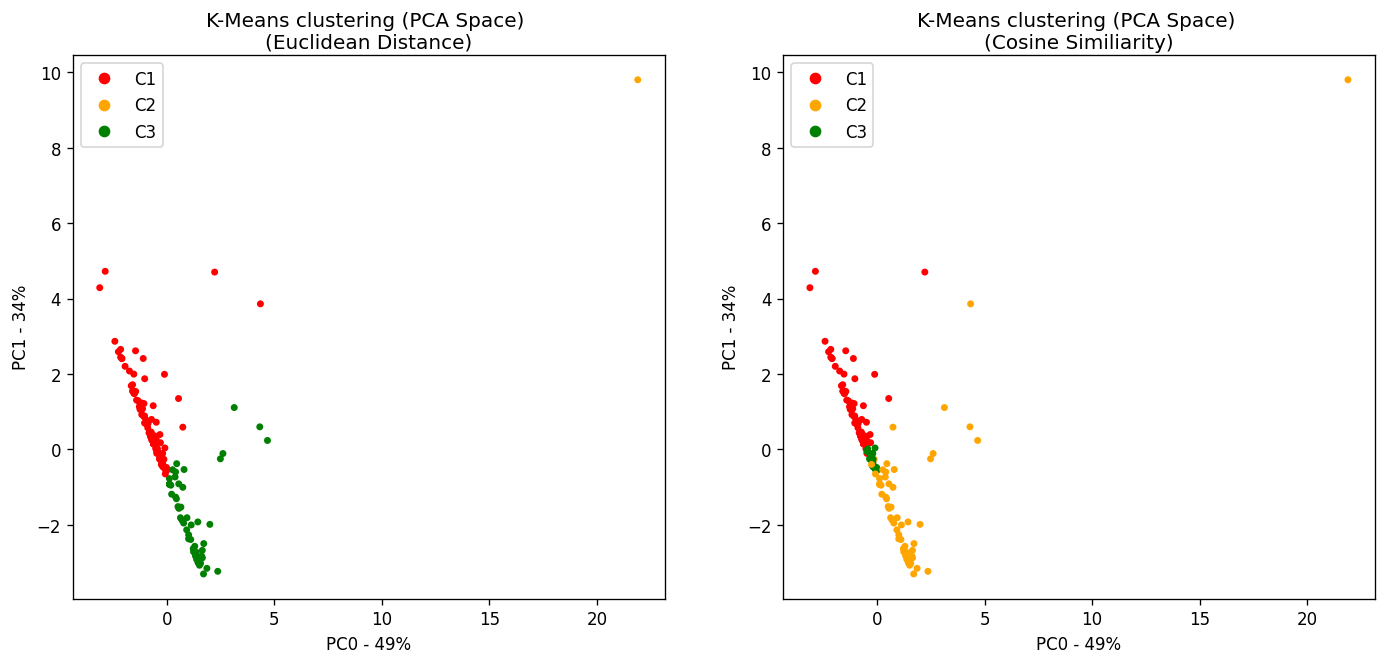

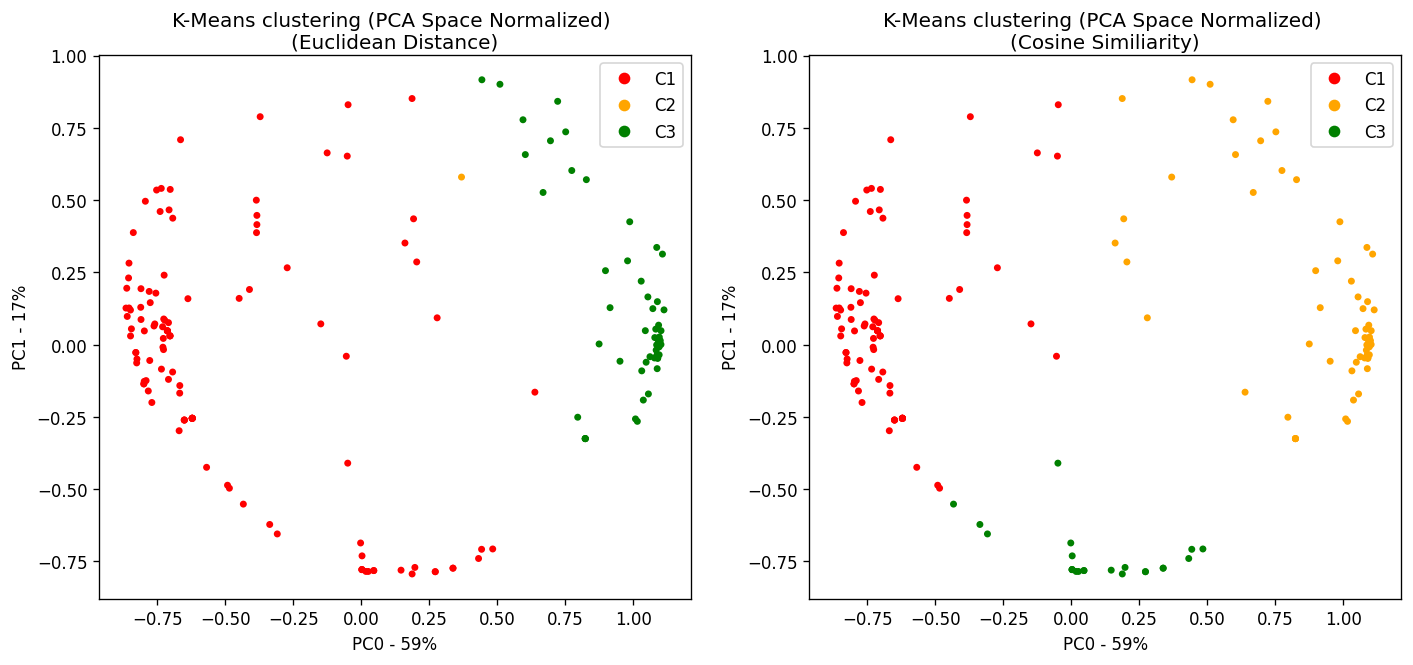

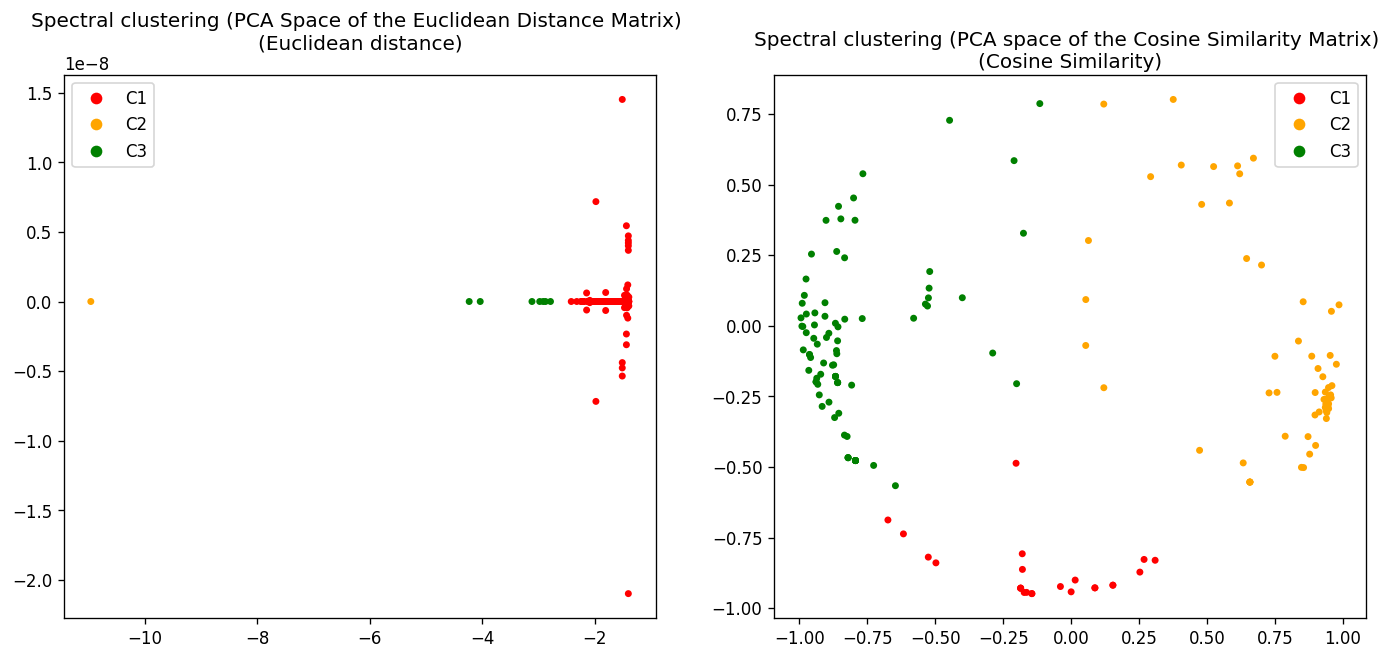

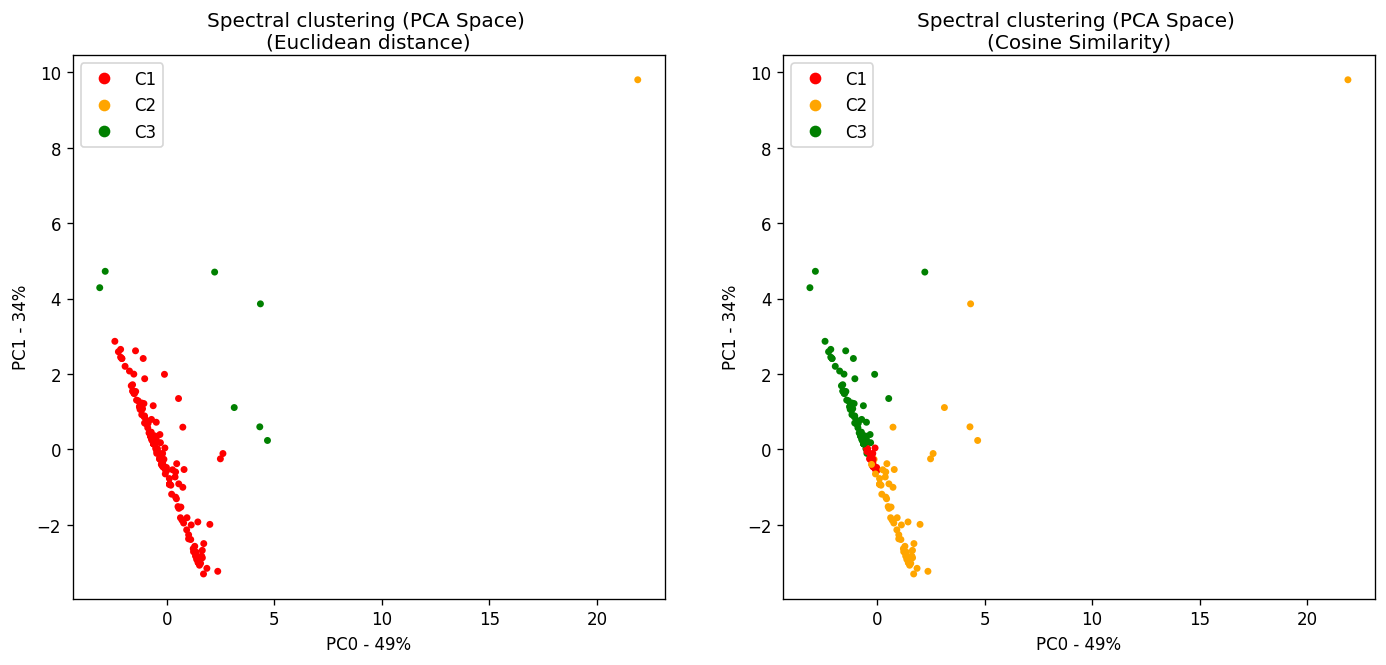

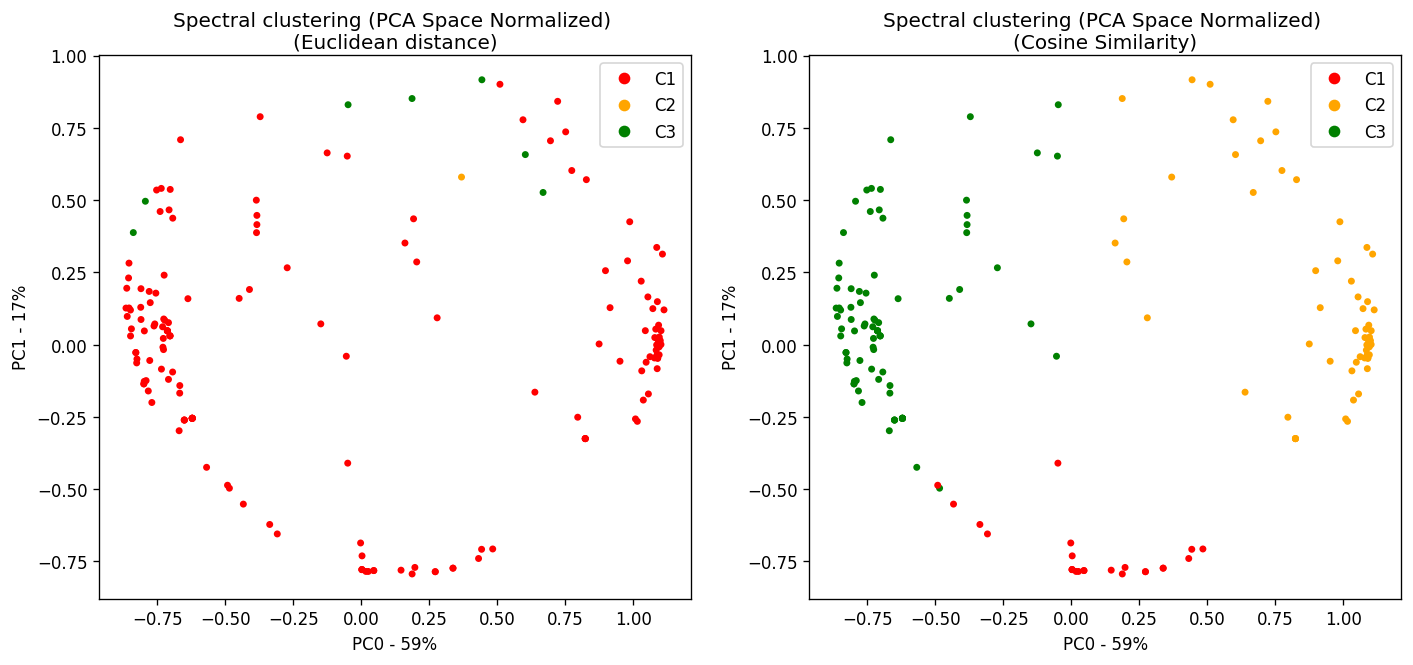

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.448510,0.442898,0.630338,0.519449
Spectral,0.795516,0.017020,0.760789,0.523976


In [8]:
# Q B-3
def fullAnalysis(pdBooksFeatures):
    kmeansEucli, kmeansCos = displayKmeansClustering(pdBooksFeatures[CRITERIAS])
    kmeansEucliNorm, kmeansCosNorm = displayKmeansClustering(pdBooksFeatures[CRITERIAS], normalizePca=True)
    spectralEucli, spectralCos, _, _, _, _ = displaySpectralClustering(
        pdBooksFeatures[CRITERIAS], 
        kmeansEucli,
        kmeansCos,
        kmeansEucliNorm,
        kmeansCosNorm
    )
    displayAccuracyMatrix(
        pdBooksFeatures, 
        (kmeansEucli, kmeansCos), 
        (spectralEucli, spectralCos)
    )

classesCount = [ (pdBooks.Class.values == i).sum() for i in range(0, 3) ]
nbSamples = np.min(classesCount)
pdBooksSampled = pdBooks.groupby('Class', group_keys=False).apply(lambda x: x.sample(nbSamples))
display(pdBooksSampled)

pdSampledBooksFeatures = getBookStats(pdBooksSampled)
display(pdSampledBooksFeatures)
displayDifferentClassesCount(pdSampledBooksFeatures)

fullAnalysis(pdSampledBooksFeatures)